[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/agents/self_querying_agent_mongodb_unstructured.ipynb)

[![View Article](https://img.shields.io/badge/View%20Article-blue)](https://www.mongodb.com/developer/products/atlas/advanced-rag-metadata-filtering/?utm_campaign=devrel&utm_source=cross-post&utm_medium=organic_social&utm_content=https%3A%2F%2Fgithub.com%2Fmongodb-developer%2FGenAI-Showcase&utm_term=apoorva.joshi)

# Advanced RAG: Metadata Extraction and Self-Querying Retrieval

This notebook shows how to incorporate metadata filtering and self-querying retrieval into a RAG application using Unstructured, MongoDB and LangGraph.

## Step 1: Install required libraries

- **langgraph**: Python package to build controllable agents
<p>
- **openai**: Python package to interact with OpenAI APIs
<p>
- **pymongo**: Python package to interact with MongoDB databases and collections
<p>
- **sentence-transformers**: Python package to use open-source embedding models

In [1]:
! pip install -qU langgraph openai pymongo sentence-transformers


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

## Step 2: Setup prerequisites

- Set the MongoDB connection string. Follow the steps [here](https://www.mongodb.com/docs/manual/reference/connection-string/) to get the connection string from the Atlas UI.

- Set the OpenAI API key. Steps to obtain an API key as [here](https://help.openai.com/en/articles/4936850-where-do-i-find-my-openai-api-key)

In [3]:
import os
import getpass
from openai import OpenAI
from pymongo import MongoClient

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")
openai_client = OpenAI()

Enter your OpenAI API Key: ········


In [5]:
MONGODB_URI = getpass.getpass("Enter your MongoDB connection string:")
mongodb_client = MongoClient(MONGODB_URI, appname="devrel.content.selfquery_mongodb_unstructured")

Enter your MongoDB connection string: ········


## Step 3: Instantiate the LLM

In [6]:
llm = "gpt-4o-2024-08-06"

## Step 4: Define agent graph state

In [7]:
from typing_extensions import TypedDict
from typing import Any, List, Dict

In [8]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: User query
        metadata: Metadata dictionary
        filter: MQL filter definition
        documents: List of documents
        generation: LLM generation
    """

    question: str
    metadata: Dict[str, List]
    filter: Dict[str, Any]
    context: List[str]
    generation: str

## Step 5: Define agent graph nodes 

### Metadata Extractor

In [9]:
from pydantic import BaseModel, Field
from datetime import datetime

In [10]:
companies = ["AT&T INC.",
 "American International Group, Inc.",
 "Apple Inc.",
 "BERKSHIRE HATHAWAY INC.",
 "Bank of America Corporation",
 "CENCORA, INC.",
 "CVS HEALTH CORPORATION",
 "Cardinal Health, Inc.",
 "Chevron Corporation",
 "Citigroup Inc.",
 "Costco Wholesale Corporation",
 "Exxon Mobil Corporation",
 "Ford Motor Company",
 "GENERAL ELECTRIC COMPANY",
 "GENERAL MOTORS COMPANY",
 "HP Inc.",
 "INTERNATIONAL BUSINESS MACHINES CORPORATION",
 "JPMorgan Chase & Co.",
 "MICROSOFT CORPORATION",
 "MIDLAND COMPANY",
 "McKESSON CORPORATION",
 "THE BOEING COMPANY",
 "THE HOME DEPOT, INC.",
 "THE KROGER CO.",
 "The Goldman Sachs Group, Inc.",
 "UnitedHealth Group Incorporated",
 "VALERO ENERGY CORPORATION",
 "Verizon Communications Inc.",
 "WALMART INC.",
 "WELLS FARGO & COMPANY"]

In [11]:
class Metadata(BaseModel):
    """Metadata to use for pre-filtering."""
    company: list[str] = Field(description="List of company names")
    year: list[str] = Field(description="List containing start year and end year")

In [12]:
def extract_metadata(state):
    """
    Extract metadata from natural language query.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state i.e. metadata containing the metadata extracted from the user query.
    """
    print("---EXTRACTING METADATA---")
    question = state["question"]
    system = f"""Extract the specified metadata from the user question:
    - company: List of company names, eg: Google, Adobe etc. Match the names to companies on this list: {companies}
    - year: List of [start year, end year]. Guidelines for extracting dates:
        - If a single date is found, only include that.
        - For phrases like 'in the past X years/last year', extract the start year by subtracting X from the current year. The current year is {datetime.now().year}.
        - If more than two dates are found, only include the smallest and the largest year."""
    completion = openai_client.beta.chat.completions.parse(
    model=llm,
    messages=[
        {"role": "system", "content": system},
        {"role": "user", "content": question},
        ],
        response_format=Metadata,
    )
    result = completion.choices[0].message.parsed
    if len(result.company) == 0 and len(result.year) == 0:
        return {"metadata": {}}
    metadata = {"metadata.custom_metadata.company": result.company, "metadata.custom_metadata.year": result.year}
    return {"metadata": metadata}

### MQL Filter Generator

In [13]:
import json

In [14]:
def generate_mql_filter(state):
    """
    Generate MongoDB Query Language (MQL) filter definition.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state i.e. filter containing the MQL filter.
    """
    print("---GENERATING FILTER DEFINITION---")
    metadata = state["metadata"]
    system = """Generate a MongoDB filter definition from the provided fields. Follow the guidelines below:
    - Respond in JSON with the filter assigned to a `filter` key.
    - The field `metadata.custom_metadata.company` is a list of companies.
    - The field `metadata.custom_metadata.year` is a list of one or more years.
    - If any of the provided fields are empty lists, DO NOT include them in the filter.
    - If both the metadata fields are empty lists, return an empty dictionary {{}}.
    - The filter should only contain the fields `metadata.custom_metadata.company` and `metadata.custom_metadata.year`
    - The filter can only contain the following MQL match expressions:
        - $gt: Greater than
        - $lt: Lesser than
        - $gte: Greater than or equal to
        - $lte: Less than or equal to
        - $eq: Equal to
        - $ne: Not equal to
        - $in: Specified field value equals any value in the specified array
        - $nin: Specified field value is not present in the specified array
        - $nor: Logical NOR operation
        - $and: Logical AND operation
        - $or: Logical OR operation 
    - If the `metadata.custom_metadata.year` field has multiple dates, create a date range filter using expressions such as $gt, $lt, $lte and $gte
    - If the `metadata.custom_metadata.company` field contains a single company, use the $eq expression
    - If the `metadata.custom_metadata.company` field contains multiple companies, use the $in expression 
    - To combine date range and company filters, use the $and operator
    """
    completion = openai_client.chat.completions.create(
        model=llm,
        temperature = 0,
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": f"Fields: {metadata}"},
            ],
        response_format={"type": "json_object"},
    )
    result = json.loads(completion.choices[0].message.content)
    return {"filter": result.get("filter", {})}

### MongoDB Atlas Vector Search

To perform vector search, first [create a vector search index](https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-type/) with the following index definition:

```
{
  "fields": [
    {
      "type": "vector",
      "path": "embeddings",
      "numDimensions": 768,
      "similarity": "cosine"
    },
    {
      "type": "filter",
      "path": "metadata.custom_metadata.company"
    },
    {
      "type": "filter",
      "path": "metadata.custom_metadata.year"
    }
  ]
}
```

In [15]:
from sentence_transformers import SentenceTransformer

/Users/apoorva.joshi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [16]:
embedding_model = SentenceTransformer("BAAI/bge-base-en-v1.5")

/Users/apoorva.joshi/.pyenv/versions/3.12.1/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
collection = mongodb_client["unstructured"]["kb_test"]

In [18]:
def vector_search(state):
    """
    Get relevant information using MongoDB Atlas Vector Search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state i.e. documents.
    """
    print("---PERFORMING VECTOR SEARCH---")
    question = state["question"]
    filter = state["filter"]
    if not filter:
        filter = {}
    query_embedding = embedding_model.encode(question).tolist()
    pipeline = [
        {
            "$vectorSearch": {
                "index": "vector_index",
                "path": "embeddings",
                "queryVector": query_embedding,
                "numCandidates": 150,
                "limit": 5,
                "filter": filter
            }
        },
        {
            "$project": {
                "_id": 0,
                "text": 1,
                "score": {"$meta": "vectorSearchScore"},
            }
        },
    ]

    # Execute the aggregation `pipeline` and store the results in `results`
    results = collection.aggregate(pipeline)
    relevant_results = [doc["text"] for doc in results if doc["score"] > 0.8]
    context = "\n\n".join([doc for doc in relevant_results])
    return {"context": context}

### Answer Generator

In [19]:
def generate_answer(state):
    """
    Generate the final answer to the user query

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state i.e. generation.
    """
    print("---GENERATING THE ANSWER---")
    question = state["question"]
    context = state["context"]
    system = f"Answer the question based only on the following context. If the context is empty or if it doesn't provide enough information to answer the question, say I DON'T KNOW"
    completion = openai_client.chat.completions.create(
        model=llm,
        temperature = 0,
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": f"Context:\n{context}\n\nQuestion:{question}"}
        ]
    )
    answer = completion.choices[0].message.content
    return {"generation": answer}

## Step 6: Define conditional edges

In [20]:
def check_metadata_extracted(state):
    """
    Check if any metadata is extracted.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---CHECK FOR METADATA---")
    metadata = state["metadata"]

    if not metadata:
        print(
            "---DECISION: SKIP TO VECTOR SEARCH---"
        )
        return "vector_search"
    else:
        print("---DECISION: GENERATE MQL FILTER---")
        return "generate_mql_filter"

## Step 7: Build the agent graph/flow

In [21]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display
from pprint import pprint

In [22]:
workflow = StateGraph(GraphState)

In [23]:
# Add nodes
workflow.add_node("extract_metadata", extract_metadata)
workflow.add_node("generate_mql_filter", generate_mql_filter)
workflow.add_node("vector_search", vector_search)
workflow.add_node("generate_answer", generate_answer)

# Add edges
workflow.add_edge(START, "extract_metadata")
workflow.add_conditional_edges(
    "extract_metadata",
    check_metadata_extracted,
    {
        "vector_search": "vector_search",
        "generate_mql_filter": "generate_mql_filter",
    },
)
workflow.add_edge("generate_mql_filter", "vector_search")
workflow.add_edge("vector_search", "generate_answer")
workflow.add_edge("generate_answer", END)

# Compile the graph
app = workflow.compile()

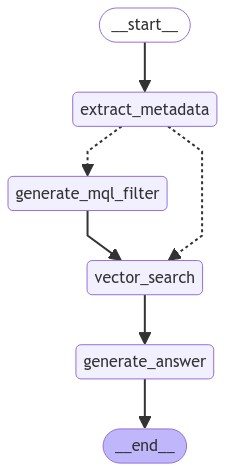

In [24]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
def run_agent(inputs):
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node {key}:")
            print(value)

In [26]:
run_agent({"question": "Give me sales summary for Walmart for 2023."})

---EXTRACTING METADATA---
---CHECK FOR METADATA---
---DECISION: GENERATE MQL FILTER---
'Node extract_metadata:'
{'metadata': {'metadata.custom_metadata.company': ['WALMART INC.'], 'metadata.custom_metadata.year': ['2023']}}
---GENERATING FILTER DEFINITION---
'Node generate_mql_filter:'
{'filter': {'$and': [{'metadata.custom_metadata.company': {'$eq': 'WALMART INC.'}}, {'metadata.custom_metadata.year': {'$eq': 2023}}]}}
---PERFORMING VECTOR SEARCH---
'Node vector_search:'
{'context': 'WALMART INC. ANNUAL REPORT ON FORM 10-K FOR THE FISCAL YEAR ENDED JANUARY 31, 2023\n\nAll references in this Annual Report on Form 10-K, the information incorporated into this Annual Report on Form 10-K by reference to information in the Proxy Statement of Walmart Inc. for its Annual Shareholders\' Meeting to be held on May 31, 2023 and in the exhibits to this Annual Report on Form 10-K to "Walmart Inc.," "Walmart," "the Company," "our Company," "we," "us" and "our" are to the Delaware corporation named "W

In [27]:
run_agent({"question": "Give me the best holiday destinations for the summer."})

---EXTRACTING METADATA---
---CHECK FOR METADATA---
---DECISION: SKIP TO VECTOR SEARCH---
'Node extract_metadata:'
{'metadata': {}}
---PERFORMING VECTOR SEARCH---
'Node vector_search:'
{'context': ''}
---GENERATING THE ANSWER---
'Node generate_answer:'
{'generation': "I DON'T KNOW"}
